Import

In [65]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2

In [66]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
image_folder = '/content/drive/MyDrive/all-images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Input and Output

In [67]:
data = pd.read_csv('/image-lightings.csv')

In [84]:
training = data.to_numpy()
print(training[0][1:3]) #testing - prints out row zero, columns 1 and 2
print("\n", training.shape)

['(1716, 1341, 3)' 0.4406199]

 (51, 7)


In [70]:
training_filenames = training[:,0]
training_labels = training[:, -1]

In [85]:
#list_images = os.listdir(image_folder) #iterates through each file in the drive folder

# Load and resize images
loaded_images = []
for filename in training_filenames: # Load all training images
    img_path = os.path.join(image_folder, filename)
    img = cv2.imread(img_path) # Load
    img = cv2.resize(img, (28, 28)) # Resize to 28x28
    loaded_images.append(img)

# Convert loaded_images to a numpy array for consistent shape
loaded_images = np.array(loaded_images)


### Creating the structure of the model

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten,Dropout

In [73]:
model = models.Sequential([
    layers.Input(shape=(28,28,3)), #3 --- 3 color channels
    layers.Conv2D(32, (3, 3), activation='relu'), #Convolutional layer-- 32 filters, 3x3 size kernels
    layers.MaxPooling2D(2, 2), #reducing spatial dimentions by returning the max value within 2x2 window
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(), #flattens data into a one-d vector (necessary befor passing to dense layers)
    layers.Dense(64, activation='relu'), #layer of 64 neurons
    layers.Dropout(0.2), #20% of previous neurons >> 0 --- this prevents overfitting (loop of loss)
    layers.Dense(3, activation='softmax')  # Softmax creates a probability distribution over the 3 output classes
])


### Testing Sparse Categorical Crossentropy:

In [74]:
def sparse_categorical_crossentropy():
  # Convert string labels to numerical labels
  tf.keras.optimizers.Adam(learning_rate=0.00001)

  label_mapping = {label: i for i, label in enumerate(np.unique(training_labels))}
  training_labels_numerical = np.array([label_mapping[label] for label in training_labels])

  # Reshape images to include channel dimension
  training_images_reshaped = np.zeros((len(training_filenames), 28, 28, 1))
  for i in range(len(loaded_images)):
    training_images_reshaped = np.array([img.reshape(28, 28, 1) for img in loaded_images])
    training_images_reshaped = training_images_reshaped.astype('float32') / 255.0

  loss=0

  model.compile(optimizer='adam', #back-propagations
                #loss functions(uses neg log likelihood)
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']) # num correct/ num images in set

  history=model.fit(  #let it run for 30 run-throughs
      training_images_reshaped,
      training_labels_numerical,
      epochs=20
  )

  lossArr2 = history.history['loss']
  return lossArr2



### Function for Sparse Focal Loss --- used for unbalanced datasets to increase probability of choosing the outliers of the data

In [75]:
from tensorflow.keras import backend as K

def sparse_focal_loss(gamma, alpha):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        cross_entropy = -y_true_one_hot * tf.math.log(y_pred)
        focal_loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy ###Focal losss formula
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))
    return loss

In [80]:
def sparse_focal():
  tf.keras.optimizers.Adam(learning_rate=0.00001) #reduce learning rate to prevent overstepping

  label_mapping = {} #creating a dictionary of generated labels
  for i, label in enumerate(np.unique(training_labels)):
    label_mapping[label] = i

  training_labels_numerical = np.array([label_mapping[label] for label in training_labels])

  # Reshape images to include channel dimension
  training_images_reshaped = np.zeros((len(training_filenames), 28, 28, 3))
  for i in range(len(loaded_images)):
    training_images_reshaped = np.array([img.reshape(28, 28, 3) for img in loaded_images])
    training_images_reshaped = training_images_reshaped.astype('float32') / 255.0

  loss=0

  model.compile(optimizer='adam', #back-propagations
                loss=sparse_focal_loss(gamma=3, alpha=0.25),
                metrics=['accuracy']) # num correct/ num images in set
  history=model.fit(  #let it run for 30 run-throughs
        training_images_reshaped,
        training_labels_numerical,
        epochs=30
    )

  lossArr = history.history['loss']
  return lossArr #returns an array of losses to be graphed

### Graphing the Loss Curves

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.2938 - loss: 0.0833
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4729 - loss: 0.0692 
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4021 - loss: 0.0682 
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5333 - loss: 0.0642 
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5771 - loss: 0.0587 
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6896 - loss: 0.0554 
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6521 - loss: 0.0471 
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6854 - loss: 0.0486
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7667 - loss: 0.0416
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8917 - loss: 0.0329
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7396 - loss: 0.0337
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8313 - loss: 0.

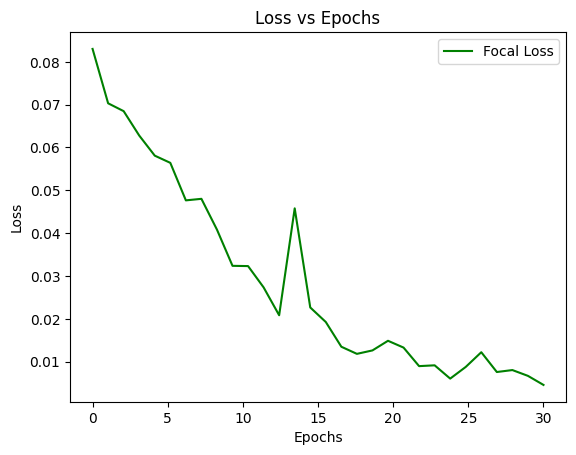

In [81]:
array1 = sparse_focal()
#array2 = sparse_categorical_crossentropy)
x = np.linspace(0, len(array1), len(array1))
plt.plot(x, array1, color='g', label="Focal Loss")
#plt.plot(x, array2, color='r',label="Categorical Cross-entropy Loss")
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
